# Income and Home Value Distributions For San Diego County

This package extracts the cumulative density function for income and home value distributions for San Diego County from the PUMS microdata for the 2015 5 year ACS.  The base data is from the 2015 5 year PUMS sample, from IPUMS<sup>[1](#ipums)</sup>. The dataset variables used are: HHINCOME and VALUEH. 


This extract is intended for analysis of senior issues in San Diego County, so the record used are further restricted with these filters: 

* WHERE AGE > 50
* HHINCOME < 9999000
* VALUEH < 9999000 
* STATEFIP = 6 
* COUNTYFIPS = 73

The limits on the HHINCOME and VALUEH variables eliminate top coding. 

## References

<a name="ipums">1</a>: Steven Ruggles, Katie Genadek, Ronald Goeken, Josiah Grover, and Matthew Sobek. Integrated Public Use Microdata Series: Version 7.0 [dataset]. Minneapolis, MN: University of Minnesota, 2017. 
https://doi.org/10.18128/D010.V7.0

In [1]:
%matplotlib inline
%load_ext metatab

%load_ext autoreload
%autoreload 2

import pandas as pd
import statsmodels  as sm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np 
import metatab as mt
import seaborn as sns; sns.set(color_codes=True)

from statsmodels.nonparametric.kde import KDEUnivariate

sns.set(color_codes=True)
plt.rcParams['figure.figsize']=(6,6)

In [2]:
%%metatab 
Origin: ipums.org
Dataset: income_homevalue
Identifier: b407e5af-cc23-431d-a431-15c202ec0c3b

Section: Contacts
Wrangler: Eric Busboom
Wrangler.Email: eric@civicknowledge.com
    
Section: Bibliography
Citation: ipums
Citation.Type: dataset
Citation.Author: Steven Ruggles, Katie Genadek, Ronald Goeken, Josiah Grover, and Matthew Sobek.
Citation.Title: Integrated Public Use Microdata Series
Citation.PublicationYear: 2017
Citation.Publisher: University of Minnesota
Citation.Version: 7.0 
Citation.AccessDate: 20170718
Citation.Location: https://usa.ipums.org/usa/index.shtml


In [3]:
%%bash
# Create a sample of a SQL database, so we can edit the schema. 
# Run the cell once to create the schema, then edit the schema and run it 
# again to build the database. 

fn='/Volumes/Storage/Downloads/usa_00004.csv'
if [ ! -e schema.sql ]
then
    head -100 $fn > sample.csv
    sqlite3 --csv ipums.sqlite '.import sample.csv ipums'
    sqlite3 ipums.sqlite  .schema > schema.sql
    sqlite3 -header ipums.sqlite "select * from ipums limit 2"  > sample.sql # Show a sample of data
    rm ipums.sqlite
fi    

if [ -e schema.sql -a \( ! -e ipums.sqlite \) ]
then
    sqlite3 ipums.sqlite < schema.sql
    sqlite3 --csv ipums.sqlite ".import $fn ipums"
    # Create some indexes to speed up queries
    sqlite3 ipums.sqlite "CREATE INDEX IF NOT EXISTS state_idx ON ipums (STATEFIP)"
    sqlite3 ipums.sqlite "CREATE INDEX IF NOT EXISTS county_idx ON ipums (COUNTYFIPS)"
    sqlite3 ipums.sqlite "CREATE INDEX IF NOT EXISTS state_county_idx ON ipums (STATEFIP, COUNTYFIPS)"
    
fi

In [4]:
import sqlite3

con = sqlite3.connect("ipums.sqlite")
incv = pd.read_sql_query(#"SELECT STATEFIP, COUNTYFIPS, AGE, HHINCOME, VALUEH "
                       "SELECT HHINCOME, VALUEH "
                       "FROM ipums "
                       "WHERE AGE > 50 AND HHINCOME < 9999000 AND VALUEH < 9999000 "
                       "AND STATEFIP = 6 AND COUNTYFIPS=73 "
                       "LIMIT 100000", con)

# Source Data

The `HHINCOME` and `VALUEH` have the typical distributions for income and home values, both of which look like Poisson distributions. 


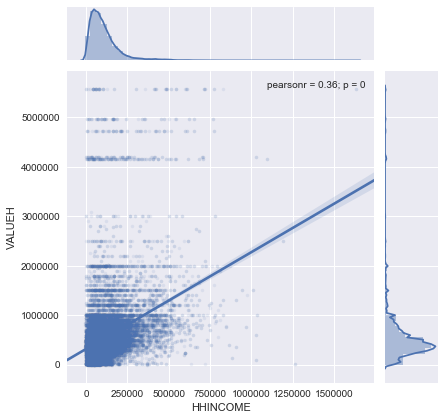

In [5]:

sns.jointplot(x="HHINCOME", y="VALUEH", marker='.', scatter_kws={'alpha': 0.1}, data=incv, kind='reg');

# Procedure

After extracting the data for HHINCOME and VALUEH, we rank both values and then quantize the rankings into 10 groups, 0 through 9, `hhincome_group` and `valueh_group`. The `HHINCOME` variable correlates with `VALUEH` at .36, and the quantized rankings `hhincome_group` and `valueh_group` correlate at .38.


In [6]:

incv['valueh_rank'] = incv.rank()['VALUEH']
incv['valueh_group'] = pd.qcut(incv.valueh_rank, 10, labels=False )
incv['hhincome_rank'] = incv.rank()['HHINCOME']
incv['hhincome_group'] = pd.qcut(incv.hhincome_rank, 10, labels=False )
incv[['HHINCOME', 'VALUEH', 'hhincome_group', 'valueh_group']] .corr()

,HHINCOME,VALUEH,hhincome_group,valueh_group
HHINCOME,1.000000,0.360709,0.797560,0.386725
VALUEH,0.360709,1.000000,0.273072,0.659567
hhincome_group,0.797560,0.273072,1.000000,0.397724
valueh_group,0.386725,0.659567,0.397724,1.000000


Then, we group the dataset by `valueh_group` and collect all of the income values for each group. These groups have different distributions, with the lower numbered group shewing to the left and the higher numbered group skewing to the right. 

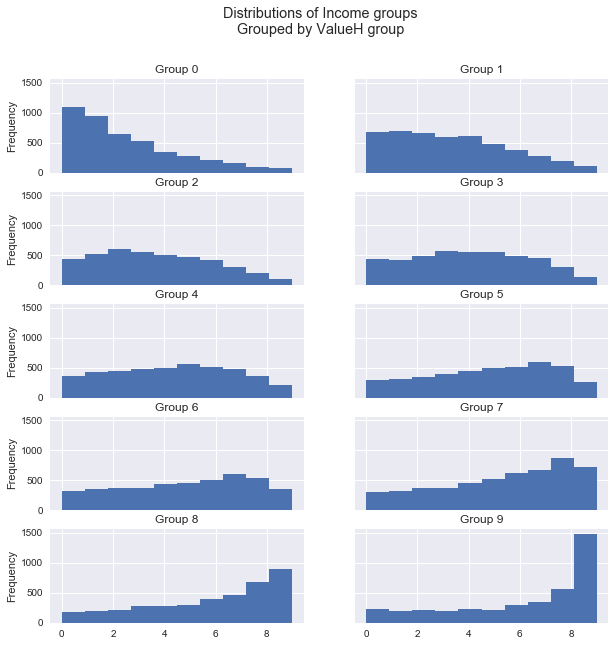

In [7]:
import matplotlib.pyplot as plt
import numpy as np

fig,AX = plt.subplots(5, 2, sharex=True, sharey=True, figsize=(10,10))

for i, ax in enumerate(AX.flatten()):
    g = incv.groupby('valueh_group').get_group(i).hhincome_group
    g.plot.hist(ax=ax, title='Group {}'.format(i))

fig.suptitle('Distributions of Income groups\nGrouped by ValueH group')
plt.show()

To use these groups in a simulation, the user would select a group for a subject's home value, then randomly select an income in that group. When this is done many times, the original `VALUEH` correlates to the new distribution ( here, as `t_income` ) at .33, reasonably similar to the original correlations. 

In [8]:
# Group the dataset by home value, then estract CDFs of 
# income for each of the home values. 
#size = 1        # sample size
#replace = True  # with replacement
#fn = lambda obj: obj.loc[np.random.choice(obj.index, size, replace),:]

income_groups = [ group.HHINCOME.sort_values() for name, group in incv.groupby('valueh_group')]

def select_income(hv_group):
    return np.random.choice(income_groups[hv_group])



In [9]:
t = incv.copy()
t['t_income'] = t.valueh_group.apply(lambda hv_group: np.random.choice(income_groups[hv_group]))
t[['HHINCOME','VALUEH','t_income']].corr()

,HHINCOME,VALUEH,t_income
HHINCOME,1.000000,0.360709,0.180506
VALUEH,0.360709,1.000000,0.309713
t_income,0.180506,0.309713,1.000000


A scatter matrix show similar structure for `VALUEH` and `t_income`.

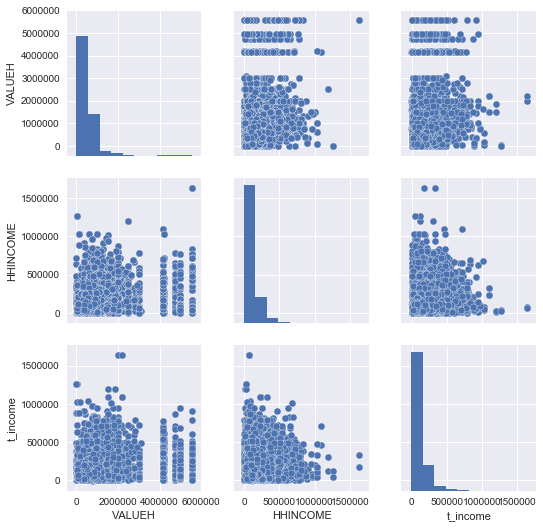

In [10]:
sns.pairplot(t[['VALUEH','HHINCOME','t_income']]);

The simulated incomes also have the same basic statistics as the original incomes. 

In [11]:
t[['VALUEH','HHINCOME','t_income']].describe()

,VALUEH,HHINCOME,t_income
count,4.365100e+04,4.365100e+04,4.365100e+04
mean,5.316370e+05,1.095317e+05,1.097545e+05
std,5.444386e+05,1.004241e+05,1.014869e+05
min,0.000000e+00,-7.500000e+03,-7.500000e+03
25%,3.000000e+05,4.670000e+04,4.635000e+04
50%,4.000000e+05,8.440000e+04,8.430000e+04
75%,6.000000e+05,1.381750e+05,1.380000e+05
max,5.567000e+06,1.636000e+06,1.636000e+06


In [12]:
from metatab.pands import MetatabDataFrame
mt = MetatabDataFrame(incv)
mt.name = 'income_homeval'
mt.title = 'Income and Home Value Records for San Diego County'
mt.HHINCOME.description = 'Household income'
mt.VALUEH.description = 'Home value'
mt.valueh_rank.description = 'Rank of the VALUEH value'
mt.valueh_group.description = 'The valueh_rank value quantized into 10 bins, from 0 to 9'
mt.hhincome_rank.description = 'Rank of the HHINCOME value'
mt.hhincome_group.description = 'The hhincome_rank value quantized into 10 bins, from 0 to 9'

%mt_add_dataframe mt  --materialize